In [8]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
import pymorphy2
import re
import string
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from datetime import datetime

tqdm.pandas()
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

from multiprocessing import Pool
morph = pymorphy2.MorphAnalyzer()

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mchelushkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Подготовка данных

In [2]:
commentsDF = pd.read_csv('data/commentsRAW.csv', usecols=['id', 'date', 'text'])
answersDF = pd.read_csv('data/answersRAW.csv', usecols=['id', 'date', 'text'])
commentsDF = commentsDF[commentsDF.text.notna()]
answersDF = answersDF[answersDF.text.notna()]

In [3]:
allCommentsDF = commentsDF.append(answersDF, ignore_index=True)
allCommentsDF.shape

(1433391, 3)

In [4]:
sortedDF = allCommentsDF.sort_values(by=['date'])

In [5]:
punctuation = string.punctuation + '…«»—–'
def clean_text(text):
# Make text lowercase
    text = text.lower()
# remove text in square brackets
    text = re.sub(r'\[.*?\]', ' ', text)
# remove urls
    text = re.sub(r"http\S+", ' ', text)
# remove punctuation
    text = re.sub(r'[%s]' % re.escape(punctuation), ' ', text)
# remove numbers
    text = re.sub(r'[0-9]', ' ', text)
# remove non letters
    text = re.sub(r'[^\w\s]', '', text)
# remove dublicate spaces
    text = re.sub('\s\s+', ' ', text)
    return text
# comments_df_clean = pd.DataFrame(allCommentsDF.text.progress_apply(lambda x: clean_text(x)))
comments_df_clean = pd.DataFrame(sortedDF.text.progress_apply(lambda x: clean_text(x)))

100%|██████████| 1433391/1433391 [00:29<00:00, 48118.09it/s]


In [6]:
%%time

stopwords_list = stopwords.words('russian') + stopwords.words('english')
stopwords_list.append('это')
stopwords_list.append('всё')
stopwords_list.append('ещё')
stopwords_list.append('весь')
stopwords_list.append('человек')
stopwords_list.append('свой')
stopwords_list.append('который')
stopwords_list.append('мочь')
stopwords_list.append('год')
stopwords_list.append('')
stopwords_list.append('p')
stopwords_list.append('c')
stopwords_list.append('de')
stopwords_list.append('b')
stopwords_list.append('ваш')
stopwords_list.append('либо')

def lemmatize(text, lemmer = morph, stopwords = stopwords_list):
    words = text.split(' ')
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if len(w) >= 3 and not w in stopwords]

with Pool(processes = 4) as pool:
    lemmatized = pool.starmap(lemmatize, zip(comments_df_clean.text))

CPU times: user 9.57 s, sys: 1.36 s, total: 10.9 s
Wall time: 5min 41s


In [7]:
import json
with open('DTM/lemmatized.json', 'w') as f:
    f.write(json.dumps(lemmatized))

In [5]:
import json
with open('DTM/lemmatized.json', 'r') as f:
    lemmatized = json.loads(f.read())

In [6]:
comments_lemmatized_df = pd.DataFrame({'text' : lemmatized, 'date' : sortedDF.date})

In [7]:
comments_lemmatized_df

text        date
74436   [вирус, искусственно, создаваться, очень, прос...  1578731693
74437     [снова, фармацевт, накидывать, гно, вентилятор]  1578731707
74438   [кошмарить, специально, публикация, проплатить...  1578731950
74439   [вначале, нужно, народ, напугать, прививка, пр...  1578732111
74440   [палка, конец, реально, болячка, просто, вброс...  1578732496
...                                                   ...         ...
871868  [собираться, собраться, привить, вопрос, время...  1618727698
871567  [ниточка, потерять, написать, развалиться, рез...  1618738485
871755  [идиот, думать, работать, пропаганда, образ, в...  1618738631
871568  [рассказать, бобёр, тупой, чушь, почитай, хала...  1618739068
871569  [читать, эксперт, совка, подъехать, цель, прес...  1618739188

[1433391 rows x 2 columns]

In [7]:
def wordsCount(texts):
    count = Counter()
    for words in texts:
        for word in words:
            count[word] += 1
    return count

def removeNotCommonWords(text, word_counter):
    return [word for word in text if word_counter[word] > 10]

def func(df):
    word_counter = wordsCount(df.text.values.tolist())
    
    df.text = df.text.apply(lambda x: removeNotCommonWords(x, word_counter))
    df.text = df.text.apply(lambda x: ' '.join(x))
    df.text = df.text.apply(lambda x: x.split())
    df = df[df.text.apply(lambda x: len(x) >= 20 and len(x) <= 300)]
    return df

In [8]:
clean_texts = func(comments_lemmatized_df)

In [12]:
tmp_cleaned_texts = clean_texts.copy()
tmp_cleaned_texts['formated_date'] = tmp_cleaned_texts.date.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m'))
tmp_cleaned_texts

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text        date  \
74448   [продолжать, ходить, нараспашку, шапка, дурь, ...  1578754224   
489703  [китаец, отверстие, достойный, пропасть, падши...  1578784658   
410860  [вирус, мутировать, постоянно, приспосабливать...  1579249273   
172619  [такса, пацан, начинать, южный, африка, качать...  1579550779   
172647  [удивительно, коммент, обвинение, адрес, кремл...  1579552723   
...                                                   ...         ...   
871736  [лола, чел, топить, капитализм, сказочно, бога...  1618649356   
871744  [думать, наверное, стоить, говорить, комментар...  1618657447   
871566  [мнение, провокация, уметь, беседа, держать, н...  1618691778   
871567  [ниточка, потерять, написать, развалиться, рез...  1618738485   
871568  [рассказать, бобёр, тупой, чушь, почитай, хала...  1618739068   

       formated_date  
74448        2020-01  
489703       2020-01  
410860       2020-01  
172619       2020-01  
172647       2020-01  
...              ...  
871736       2021-04  
871744       2021-04  
871566       2021-04  
871567       2021-04  
871568       2021-04  

[143145 rows x 3 columns]

In [13]:
time_slice = tmp_cleaned_texts.groupby(['formated_date']).count().date.values

In [14]:
time_slice

array([ 1252,  4298, 19548, 37113, 20847,  8601,  5379,  3869,  4977,
        8460,  7936,  6180,  4772,  3532,  4025,  1149])

# Эксперименты для запуска gensim.ldaseq

gensim.ldaseq - реализация dtm на python, позволяющая использовать LDA в качестве инициализации.

У нас, к сожалению не получилось добиться тех же результатов что и у обыной DTM без инициализации.

In [13]:
dictionary = corpora.Dictionary(tmp_cleaned_texts.text)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lda.dict')

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
corpus = [dictionary.doc2bow(text) for text in tmp_cleaned_texts.text]
corpora.MmCorpus.serialize('lda_gensim.model', corpus)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
params = {
#     'num_topics': [15, 20, 25, 30, 35, 40, 45, 50],
    'num_topics': [10, 15, 20, 25],
    'iterations': [5, 10, 15, 20, 25, 50],
    'passes': [1, 3, 5, 10, 15, 20, 25],
    'gamma_threshold': [0.0001, 0.001, 0.01, 0.1],
    'random_state': [42]
}

100%|██████████| 4/4 [11:36<00:00, 174.03s/it]


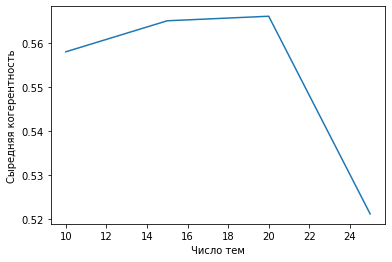

In [26]:
coherences = []

for x in tqdm(params['num_topics']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=x, passes=3, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_num_topics = params['num_topics'][np.argmax(coherences)]

plt.plot(params['num_topics'], coherences)
plt.xlabel("Число тем")
plt.ylabel("Сыредняя когерентность")
plt.show()

100%|██████████| 6/6 [13:01<00:00, 130.22s/it]


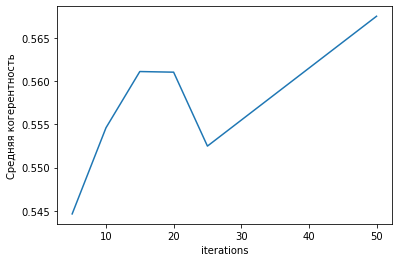

In [29]:
coherences = []

for x in tqdm(params['iterations']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, iterations=x, passes=3, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_iterations = params['iterations'][np.argmax(coherences)]
plt.plot(params['iterations'], coherences)
plt.xlabel("iterations")
plt.ylabel("Средняя когерентность")
plt.show()

100%|██████████| 7/7 [45:08<00:00, 386.89s/it]


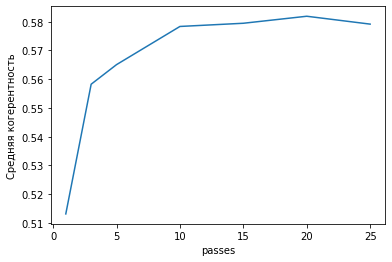

In [30]:
coherences = []

for x in tqdm(params['passes']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, passes=x, iterations=20, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_passes = params['passes'][np.argmax(coherences)]

plt.plot(params['passes'], coherences)
plt.xlabel("passes")

plt.ylabel("Средняя когерентность")
plt.show()

In [33]:
%%time
# BEST
lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=20, passes=10, iterations=50, random_state=42)
# lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=24, passes=5, iterations=20, random_state=42)
# lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=25, passes=15, gamma_threshold=0.1, iterations=25, random_state=42)
# previous try
# lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=15, passes=10, iterations=20, gamma_threshold = 0.004, random_state=42)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 6min 2s, sys: 15 s, total: 6min 17s
Wall time: 6min 44s


In [35]:
lda.save('DTM/models/lda_n20/lda.model')

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
lda = LdaMulticore.load('DTM/models/lda_n20/lda.model')

In [21]:
from gensim.models import ldaseqmodel

In [19]:
%%time

ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=20, lda_model=lda)

CPU times: user 2d 18h 38min 45s, sys: 28min 22s, total: 2d 19h 7min 8s
Wall time: 2d 19h 42min 23s


In [20]:
ldaseq.save('DTM/models/ldaseq/lda.model')

In [25]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis
pyLDAvis.enable_notebook()

doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=10, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


# Обучение DTM - эксперименты

In [18]:
import logging
import os
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [26]:
logger.setLevel(logging.CRITICAL)

In [34]:
%%time
dtm_path = "/home/mchelushkin/Downloads/dtm-linux64"

model = DtmModel(dtm_path, corpus, time_slices=[len(corpus)], num_topics=15, id2word=dictionary, initialize_lda=True, alpha=0.01, top_chain_var=0.005)

INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /tmp/8b96cc_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /tmp/8b96cc_train-mult.dat
DEBUG:smart_open.smart_open_lib:{'uri': '/tmp/8b96cc_train-mult.dat', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.corpora.bleicorpus:saving vocabulary of 21931 words to /tmp/8b96cc_train-mult.dat.vocab
DEBUG:smart_open.smart_open_lib:{'uri': '/tmp/8b96cc_train-mult.dat.vocab', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
DEBUG:smart_open.smart_open_lib:{'uri': '/tmp/8b96cc_train-seq.dat', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': Non

CPU times: user 17.8 s, sys: 378 ms, total: 18.2 s
Wall time: 2h 6min 6s


In [36]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis
pyLDAvis.enable_notebook()

doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [37]:
%%time
dtm_path = "/home/mchelushkin/Downloads/dtm-linux64"

model = DtmModel(dtm_path, corpus, time_slices=[len(corpus)], num_topics=15, id2word=dictionary, initialize_lda=True, alpha=0.1, top_chain_var=0.005)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /tmp/c4e08b_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /tmp/c4e08b_train-mult.dat
DEBUG:smart_open.smart_open_lib:{'uri': '/tmp/c4e08b_train-mult.dat', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.corpora.bleicorpus:saving vocabulary of 21931 words to /tmp/c4e08b_train-mult.dat.vocab
DEBUG:smart_ope

CPU times: user 18 s, sys: 371 ms, total: 18.4 s
Wall time: 2h 22min 42s


In [38]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis
pyLDAvis.enable_notebook()

doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [39]:
model.save('DTM/models/experiments/a_0_1/dtm.model')

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.utils:saving DtmModel object under DTM/models/experiments/a_0_1/dtm.model, separately None
DEBUG:smart_open.smart_open_lib:{'uri': 'DTM/models/experiments/a_0_1/dtm.model', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.utils:saved DTM/models/experiments/a_0_1/dtm.model


In [40]:
%%time
dtm_path = "/home/mchelushkin/Downloads/dtm-linux64"

model = DtmModel(dtm_path, corpus, time_slices=[len(corpus)], num_topics=15, id2word=dictionary, initialize_lda=True, alpha=1, top_chain_var=0.005)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /tmp/a46500_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /tmp/a46500_train-mult.dat
DEBUG:smart_open.smart_open_lib:{'uri': '/tmp/a46500_train-mult.dat', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.corpora.bleicorpus:saving vocabulary of 21931 words to /tmp/a46500_train-mult.dat.vocab
DEBUG:smart_ope

CPU times: user 18.2 s, sys: 399 ms, total: 18.6 s
Wall time: 1h 32min


In [43]:
model.save('DTM/models/experiments/a_1/dtm.model')

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.utils:saving DtmModel object under DTM/models/experiments/a_1/dtm.model, separately None
DEBUG:smart_open.smart_open_lib:{'uri': 'DTM/models/experiments/a_1/dtm.model', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.utils:saved DTM/models/experiments/a_1/dtm.model


In [41]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis
pyLDAvis.enable_notebook()

doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [45]:
%%time
dtm_path = "/home/mchelushkin/Downloads/dtm-linux64"

model = DtmModel(dtm_path, corpus, time_slices=time_slice, num_topics=15, id2word=dictionary, initialize_lda=True, alpha=1, top_chain_var=0.005)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /tmp/65a5b3_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /tmp/65a5b3_train-mult.dat
DEBUG:smart_open.smart_open_lib:{'uri': '/tmp/65a5b3_train-mult.dat', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.corpora.bleicorpus:saving vocabulary of 21931 words to /tmp/65a5b3_train-mult.dat.vocab
DEBUG:smart_ope

CPU times: user 43.3 s, sys: 527 ms, total: 43.8 s
Wall time: 1h 54min 47s


In [61]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis
pyLDAvis.enable_notebook()

doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [83]:
model.save('DTM/models/experiments/months_a_1/dtm.model')

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.utils:saving DtmModel object under DTM/models/experiments/months_a_1/dtm.model, separately None
DEBUG:smart_open.smart_open_lib:{'uri': 'DTM/models/experiments/months_a_1/dtm.model', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.utils:saved DTM/models/experiments/months_a_1/dtm.model


In [19]:
%%time
dtm_path = "/home/mchelushkin/Downloads/dtm-linux64"

model = DtmModel(dtm_path, corpus, time_slices=time_slice, num_topics=15, id2word=dictionary, initialize_lda=True, alpha=1, top_chain_var=0.05)

INFO:gensim.models.wrappers.dtmmodel:serializing temporary corpus to /tmp/f57bf1_train-mult.dat
INFO:gensim.corpora.bleicorpus:no word id mapping provided; initializing from corpus
INFO:gensim.corpora.bleicorpus:storing corpus in Blei's LDA-C format into /tmp/f57bf1_train-mult.dat
DEBUG:smart_open.smart_open_lib:{'uri': '/tmp/f57bf1_train-mult.dat', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.corpora.bleicorpus:saving vocabulary of 21896 words to /tmp/f57bf1_train-mult.dat.vocab
DEBUG:smart_open.smart_open_lib:{'uri': '/tmp/f57bf1_train-mult.dat.vocab', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
DEBUG:smart_open.smart_open_lib:{'uri': '/tmp/f57bf1_train-seq.dat', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': Non

CPU times: user 42.9 s, sys: 461 ms, total: 43.4 s
Wall time: 1h 52min 4s


In [45]:
model.save('DTM/models/experiments/best_a_1_v_0_05/dtm.model')

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.utils:saving DtmModel object under DTM/models/experiments/best_a_1_v_0_05/dtm.model, separately None
DEBUG:smart_open.smart_open_lib:{'uri': 'DTM/models/experiments/best_a_1_v_0_05/dtm.model', 'mode': 'wb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.utils:saved DTM/models/experiments/best_a_1_v_0_05/dtm.model


In [20]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis
pyLDAvis.enable_notebook()

doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=10, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


# Визуализация лучшей моделей

In [10]:
from gensim.models.wrappers.dtmmodel import DtmModel
# BEST MODEL
model = DtmModel.load('DTM/models/experiments/best_a_1_v_0_05/dtm.model')
for i in range(100):
    try:
        model.show_topic(topicid=i, time=0, num_words=10)
    except:
        print(str(i) + ' - max_topicID')
        break

for i in range(100):
    try:
        model.show_topic(topicid=0, time=i, num_words=10)
    except:
        print(str(i) + ' - max_time')
        break

15 - max_topicID
16 - max_time


In [5]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

'Feb 2020'

In [25]:
from matplotlib.pyplot import figure
def visByTopicId(model, topicid, topn, words_to_keep = []):
    bestWordsForTime = {}
    for time in range(16):
        topicWords = model.show_topic(topicid, time=time, topn=100)
        topicWords_dict = {y:x for x,y in dict(topicWords).items()} 
        added = []
        for prob, word in topicWords[:topn]:
            if word in bestWordsForTime:
                bestWordsForTime[word].append((time, prob))
            else:
                bestWordsForTime[word] = [(time, prob)]
    tmp = {}
    for word in bestWordsForTime:
        for time in range(16):
            topicWords = model.show_topic(topicid, time=time, topn=10000)
            topicWords_dict = {y:x for x,y in dict(topicWords).items()}
            if word in tmp:
                tmp[word].append((time, topicWords_dict[word]))
            else:
                tmp[word] = [(time, topicWords_dict[word])]
    bestWordsForTime = tmp
    tmp = {}
    if len(words_to_keep) > 0:
        for word in words_to_keep:
            tmp[word] = bestWordsForTime[word]
        bestWordsForTime = tmp
    figure(figsize=(8, 6), dpi=80)
    for name in bestWordsForTime:
        tmp = dict(bestWordsForTime[name])
        for i in range(16):
            if i not in tmp:
                tmp[i] = None
        idcs = np.argsort(list(tmp.keys()))
        x = np.array(list(tmp.keys()))[np.argsort(list(tmp.keys()))]
        y = np.array(list(tmp.values()))[np.argsort(list(tmp.keys()))]
        plt.plot(x, y, label=name)
    x_label = [(datetime(2020, 1, 1) + relativedelta(months=x)).strftime("%b %Y") for x in range(16)]
    plt.xticks(x[::2], x_label[::2])
#     print(plt.get_xdata())
#     plt.xlabel('week number')
    plt.ylabel('Вероятность слова')
    plt.legend()
    plt.savefig('visualization/dtm'+str(topicid)+'.png')
    return plt

## TopicId 0

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

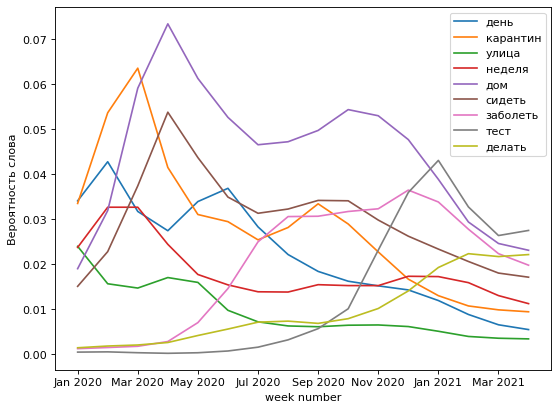

In [22]:
visByTopicId(model, topicid = 0, topn = 3)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

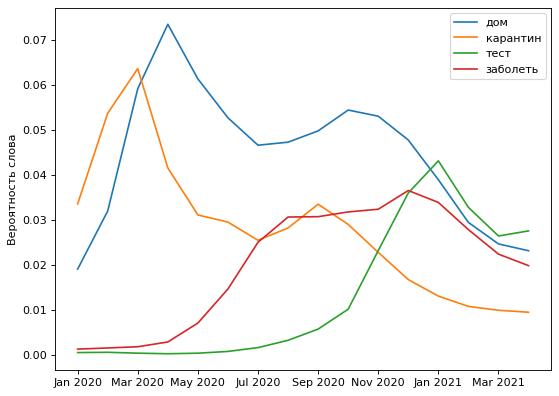

In [26]:
visByTopicId(model, topicid = 0, topn = 3, words_to_keep=['дом', 'карантин', 'тест', 'заболеть'])

## TopiId 1

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

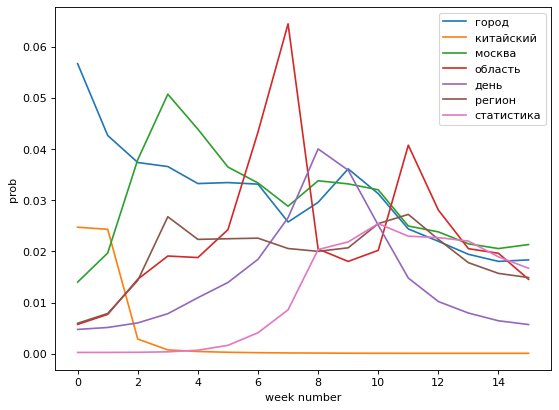

In [80]:
visByTopicId(model, topicid = 1, topn = 2)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

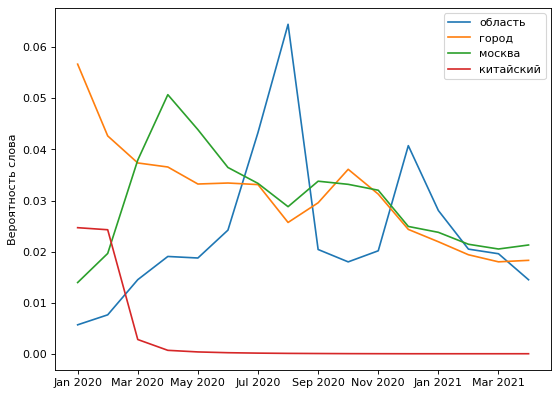

In [27]:
visByTopicId(model, topicid = 1, topn = 2, words_to_keep=['область', 'город', 'москва', 'китайский'])

## TopicId 2

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

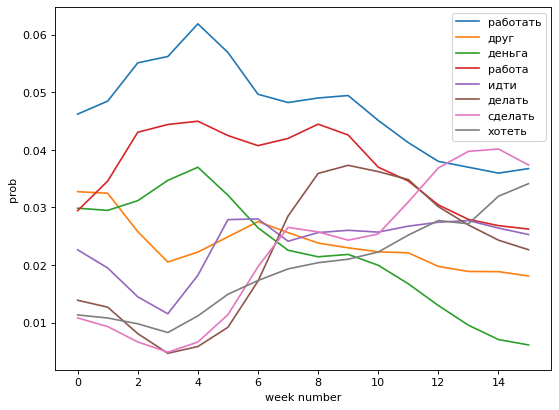

In [102]:
visByTopicId(model, topicid = 2, topn = 3)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

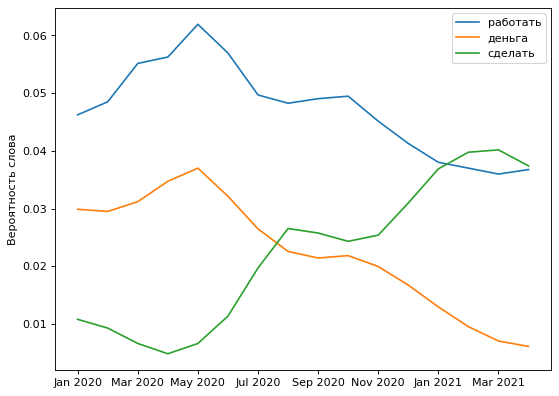

In [28]:
visByTopicId(model, topicid = 2, topn = 3, words_to_keep=['работать', 'деньга', 'сделать'])

## TopicId 3

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

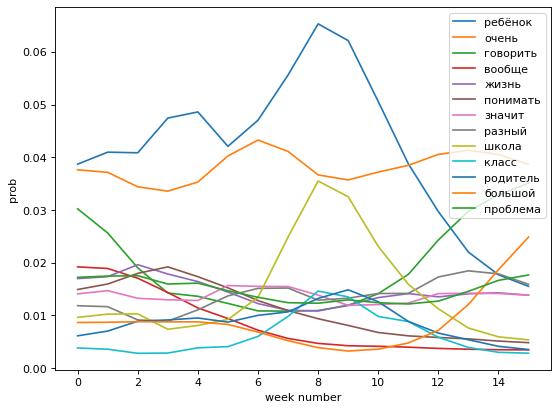

In [103]:
visByTopicId(model, topicid = 3, topn = 4)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

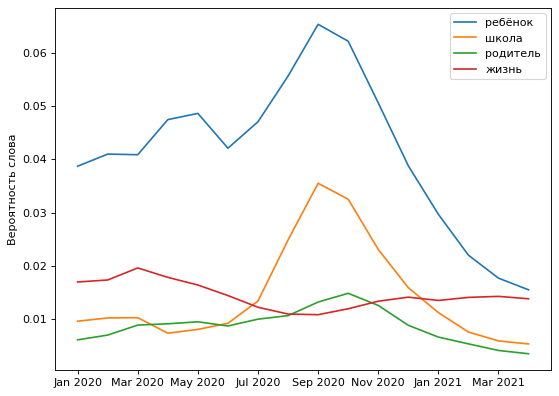

In [29]:
visByTopicId(model, topicid = 3, topn = 4, words_to_keep=['ребёнок', 'школа', 'родитель', 'жизнь'])

## TopicId 4

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

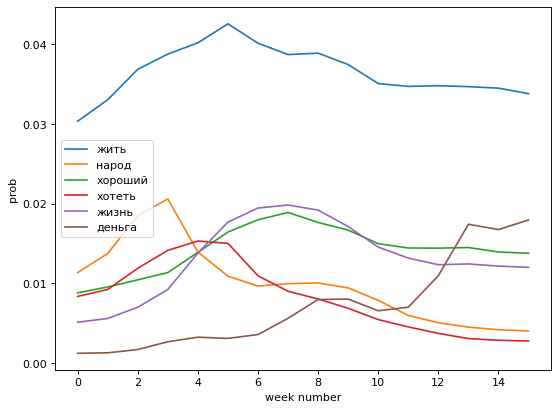

In [82]:
visByTopicId(model, topicid = 4, topn = 3)

## TopicId 5

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

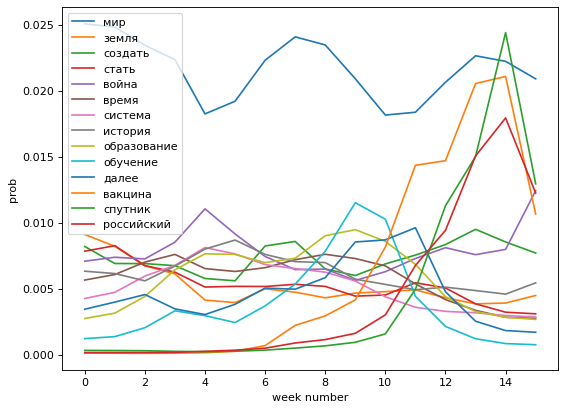

In [83]:
visByTopicId(model, topicid = 5, topn = 3)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

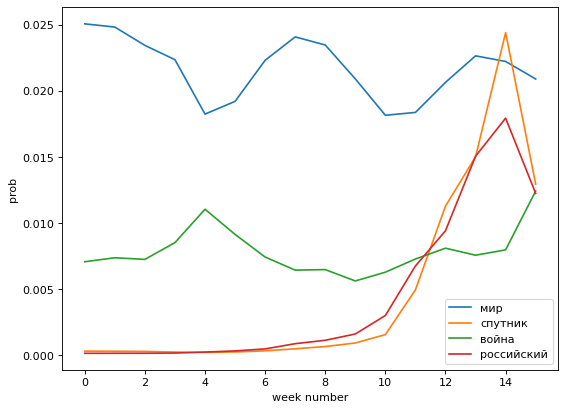

In [108]:
visByTopicId(model, topicid = 5, topn = 3, words_to_keep=['мир', 'спутник', 'война', 'российский'])

## TopicId 6

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

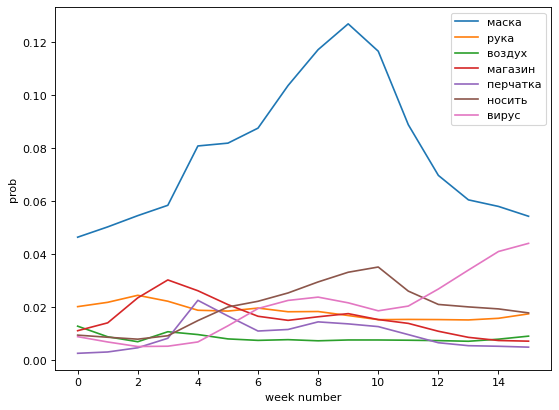

In [84]:
visByTopicId(model, topicid = 6, topn = 3)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

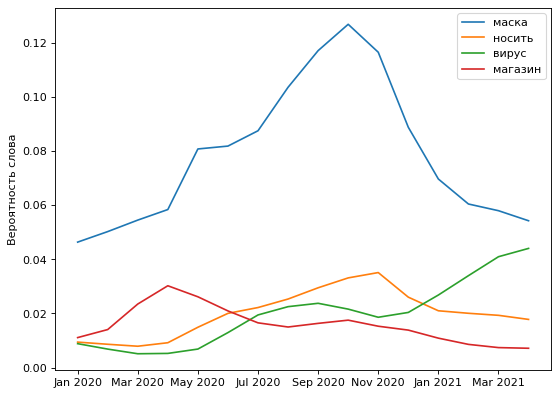

In [30]:
visByTopicId(model, topicid = 6, topn = 3, words_to_keep=['маска', 'носить', 'вирус', 'магазин'])

## TopicId 7

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

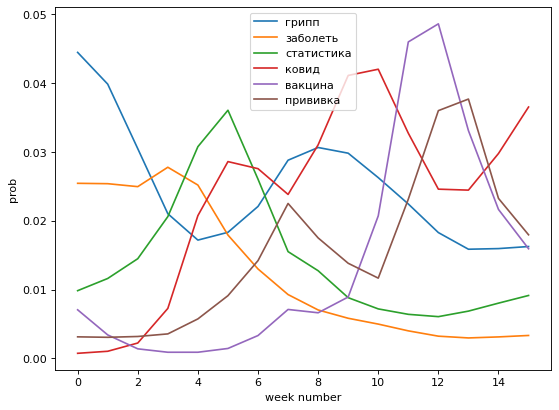

In [85]:
visByTopicId(model, topicid = 7, topn = 1)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

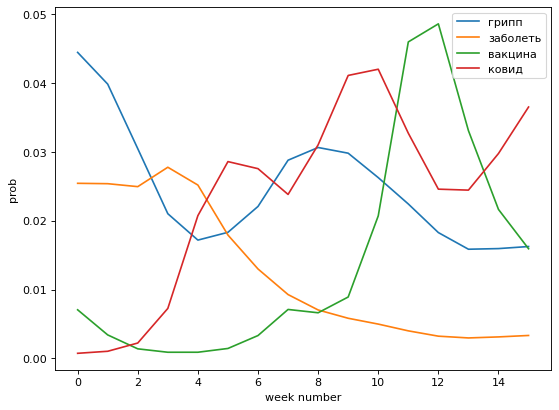

In [110]:
visByTopicId(model, topicid = 7, topn = 3, words_to_keep=['грипп', 'заболеть', 'вакцина', 'ковид'])

## TopicId 8

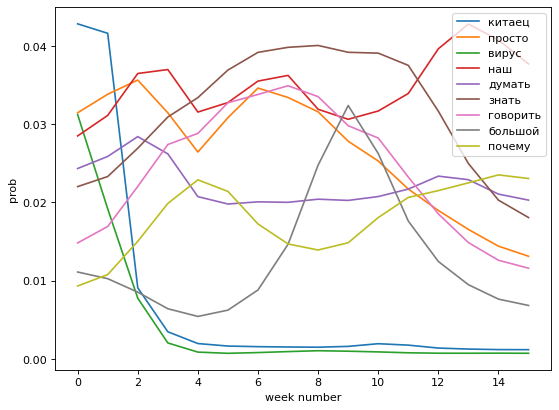

In [86]:
visByTopicId(model, topicid = 8, topn = 3).show()

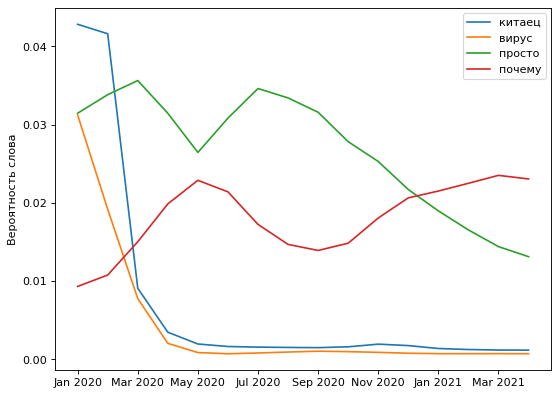

In [31]:
visByTopicId(model, topicid = 8, topn = 3, words_to_keep=['китаец', 'вирус', 'просто', 'почему']).show()

## TopicId 9

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

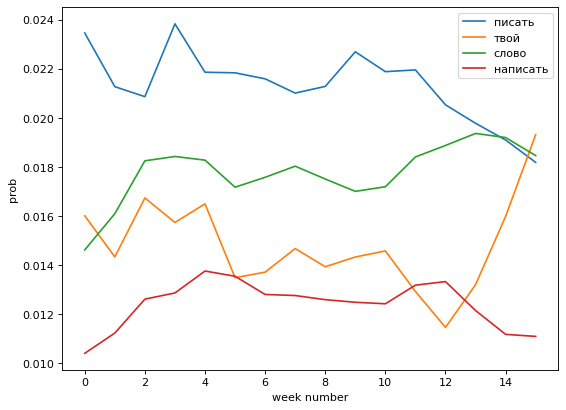

In [87]:
visByTopicId(model, topicid = 9, topn = 3)

## TopicId 10

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

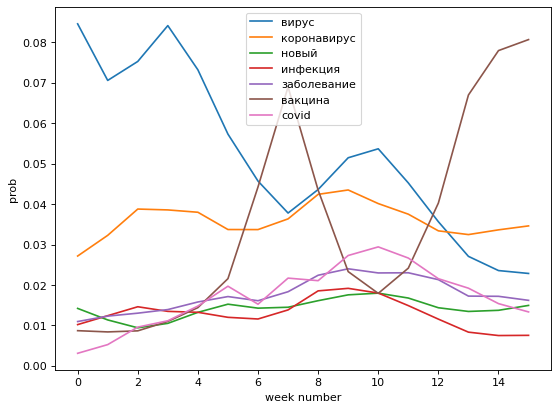

In [88]:
visByTopicId(model, topicid = 10, topn = 3)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

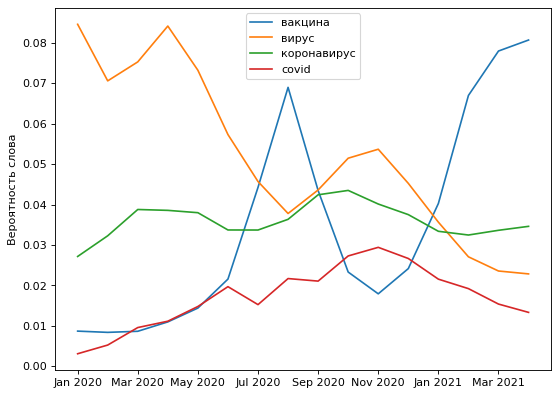

In [32]:
visByTopicId(model, topicid = 10, topn = 3, words_to_keep=['вакцина', 'вирус', 'коронавирус', 'covid'])

## TopicId 11

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

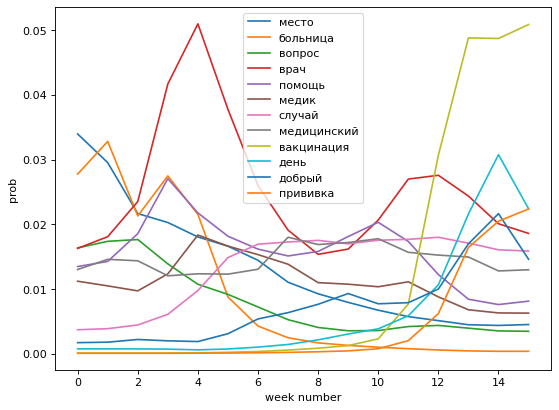

In [89]:
visByTopicId(model, topicid = 11, topn = 3)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

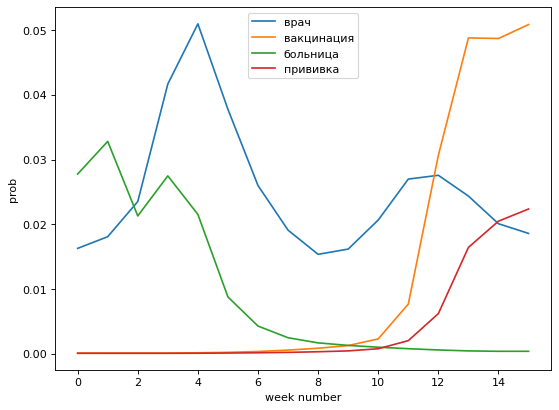

In [113]:
visByTopicId(model, topicid = 11, topn = 3, words_to_keep=['врач','вакцинация', 'больница', 'прививка'])

## TopicId 12

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

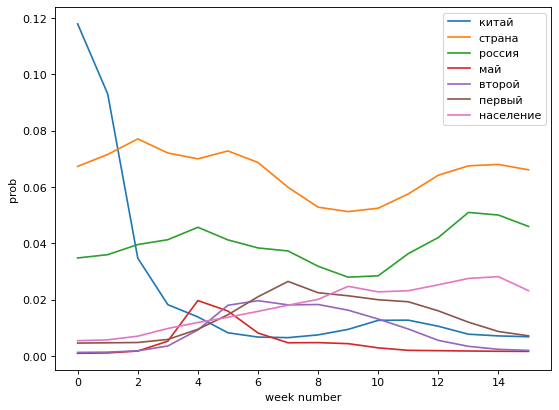

In [90]:
visByTopicId(model, topicid = 12, topn = 3)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

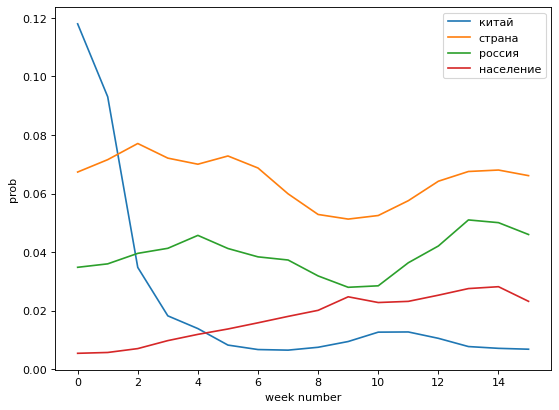

In [114]:
visByTopicId(model, topicid = 12, topn = 3, words_to_keep=['китай', 'страна', 'россия', 'население'])

## TopicId 13

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

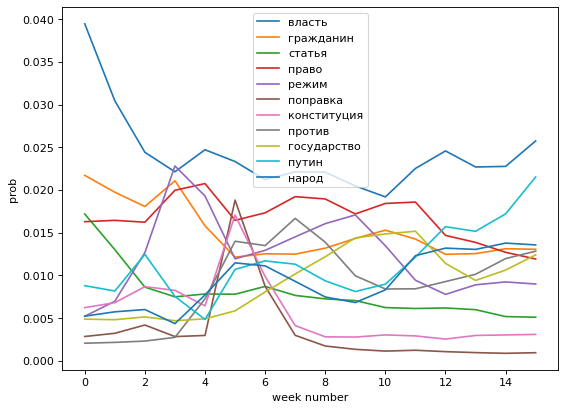

In [91]:
visByTopicId(model, topicid = 13, topn = 3)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

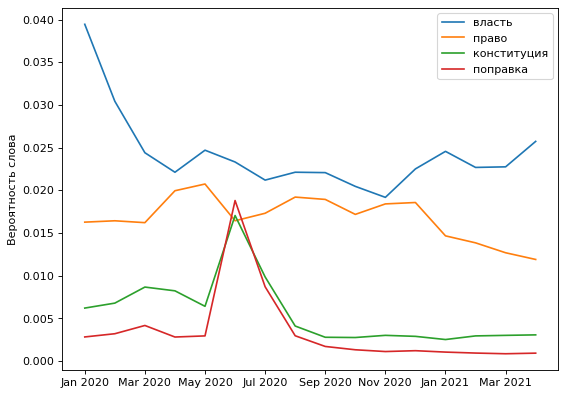

In [33]:
visByTopicId(model, topicid = 13, topn = 3, words_to_keep=['власть', 'право', 'конституция', 'поправка'])

## TopicId 14

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

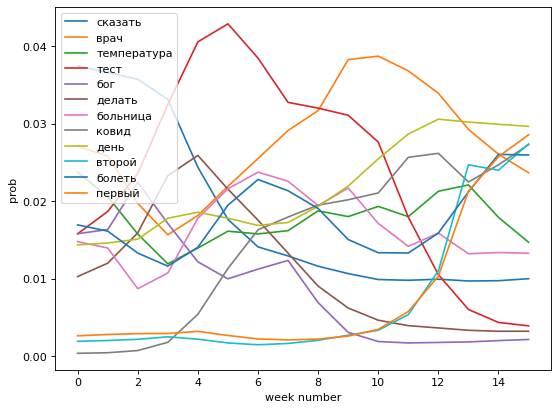

In [92]:
visByTopicId(model, topicid = 14, topn = 3)

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

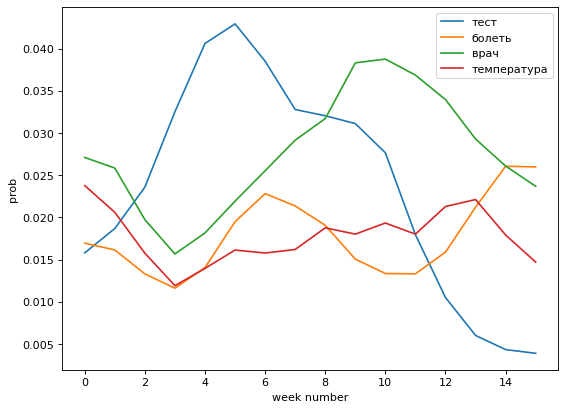

In [121]:
visByTopicId(model, topicid = 14, topn = 3, words_to_keep=['тест', 'болеть', 'врач', 'температура'])